## 2. Data understanding

In [2]:
#Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

print(sys.version)
print(np.__version__)

plt.style.use('seaborn-deep')

#load dataset
dataframe = pd.read_json('reviews_Amazon_Instant_Video_5.json',lines=True)
dataframe.info()

3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]
1.11.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


### 2.1. Data types
The features of this dataset are as follows :
+ asin - ID of the product - Nominal
+ helpful - A tuple containing the number of people that thought the review was helpful or unhelpful - Both ordinal, stored as integers
+ overall - The overall rating that a product received. Ordinal, stored as integer
+ reviewText - The full text of the review - Bag of words
+ reviewTime - The timestamp of the review - Interval
+ reviewerID - The ID of the reviewer - Nominal
+ reviewerName - The name of the reviewer - Nominal
+ summary - A summary of the review  - Bag of words
+ unixReviewTime - The UNIX timestamp of the review - Interval
   

<br/>
Additionally, we extracted the following attributes from the already existing attributes that will help us in our analysis of the dataset:
+ numberHelpful - The amount of people that thought the review was helpful, extracted from the helpful tuple. Ordinal, stored as integer
+ numberUnhelpful - The amount of people that thought the review was unhelpful, extracted from the helpful tuple. Ordinal, stored as integer
+ reviewerNumberReviews - The number of reviews each reviewer had left. Ordinal, stored as integer
+ reviewLength  - The length of the review text. Ordinal, stored as integer
+ helpfulRatio - The ratio of helpful vs. unhelpful, NaN if either is 0. Interval, stored as double


In [3]:
#extract information for number of reviews by each reviewer
reviewer_ids = list(dataframe['reviewerID'])
authorToNumReviews = {user_id:reviewer_ids.count(user_id) for user_id in set(reviewer_ids)}
dataframe['reviewLength'] = [len(text) for text in dataframe['reviewText']]
dataframe['reviewerNumberReviews'] = [authorToNumReviews[author] for author in dataframe['reviewerID']]

#extract additional columns for analysis
helpful_count = []
unhelpful_count = []
helpful_ratio = []
for (h,total) in dataframe['helpful']:
    helpful_count.append(h)
    unhelpful_count.append(total-h)
    if total == 0:
        helpful_ratio.append(None)
    else:
        helpful_ratio.append(h/(total))
dataframe['numberUnhelpful'] = unhelpful_count
dataframe['numberHelpful'] = helpful_count
dataframe['helpfulRatio'] = helpful_ratio

<br/>
We had to convert the reviewText and summary to a bag of words model to ease us in our analysis and prediction. Those were stored in two variables, <i>review_bag</i> and <i>summary_bag</i>.
<br/> <br/>


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
review_bag = count_vect.fit_transform(dataframe['reviewText'])
summary_bag = count_vect.fit_transform(dataframe['summary'])

<br/> 
We discarded the attributes we would not need for our analysis and set the appropriate storage types to those that were not already assigned. 
<br/>

In [5]:
import numpy as np
unneeded_attributes = ['unixReviewTime', 'helpful', 'reviewTime']
ordinal_attributes = ['numberHelpful', 'numberUnhelpful', 'reviewLength', 'overall', 'reviewerNumberReviews']
nominal_attributes = ['asin', 'reviewerID', 'reviewerName']
interval_attributes = ['helpfulRatio']

for attr in unneeded_attributes:
    if attr in dataframe:
        del dataframe[attr]

dataframe[interval_attributes] = dataframe[interval_attributes].astype(np.float64)
dataframe[ordinal_attributes] = dataframe[ordinal_attributes].astype(np.int64)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 11 columns):
asin                     37126 non-null object
overall                  37126 non-null int64
reviewText               37126 non-null object
reviewerID               37126 non-null object
reviewerName             36797 non-null object
summary                  37126 non-null object
reviewLength             37126 non-null int64
reviewerNumberReviews    37126 non-null int64
numberUnhelpful          37126 non-null int64
numberHelpful            37126 non-null int64
helpfulRatio             13133 non-null float64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.1+ MB


### 2.2. Data quality

The dataset that was provided was not missing any values for the attributes we wanted to use. It was, however, missing 329 reviewer names, as can be seen from the outputs below. We decided to keep this data as is, as there was another unique identifier for reviewers - reviewerID - that we could use to associate a reviewer with a review. Reviewer names were also not a part of our analysis or predicition, so it would in no way skew our results at the end. 
<br/>
The most probable reason why there were missing values for reviewerName is that Amazon had given the option to reviewers to post anonymously and had hidden their names in the review. Since only logged in members are allowed to post reviews, we can assume that the reviewerID is sufficient for us to identify reviews by the same members.
<br/>
Since a large percentage of the values we had for helpful and unhelpful ratings were 0s, the helpfulRatio attribute we calculated for 65% of our entries was NaN. We kept those values, as we could use them for prediction later on and removing each entry would eliminate certain helpful attributes such as reviewLength and overall rating given.

In [6]:
null_reviewerName = dataframe[dataframe['reviewerName'].isnull()]
null_helpfulRatio = dataframe[dataframe['helpfulRatio'].isnull()]
print("Number of entries with missing reviewerName : ", len(null_reviewerName))
print("Number of entries with missing helpfulRatio : ", len(null_helpfulRatio))

Number of entries with missing reviewerName :  329
Number of entries with missing helpfulRatio :  23993


<br/> 
Furthermore, we decided to not treat entries where numberHelpful and numberUnhelpful were 0 as missing, as it was not an erroneous entry of information, but could signify that simply no other customers found this review to be helpful or unhelpful and could damage our final result, should we choose to delete or impute these values. It can be seen that over 50% of the values have 0 for those two attributes. 
<br/>

In [7]:
dataframe.describe()

,overall,reviewLength,reviewerNumberReviews,numberUnhelpful,numberHelpful,helpfulRatio
count,37126.00000,37126.000000,37126.000000,37126.000000,37126.000000,13133.000000
mean,4.20953,515.292033,10.667026,0.725475,1.293541,0.574588
std,1.11855,835.145610,13.346323,3.532468,8.301778,0.391384
min,1.00000,4.000000,5.000000,0.000000,0.000000,0.000000
25%,4.00000,145.000000,5.000000,0.000000,0.000000,0.200000
50%,5.00000,232.000000,7.000000,0.000000,0.000000,0.666667
75%,5.00000,484.000000,10.000000,0.000000,1.000000,1.000000
max,5.00000,18152.000000,123.000000,214.000000,484.000000,1.000000


<br/>
The dataset we chose had no duplicate entries in it and eliminated the need for us to handle such a case. There were no instances where the same review was posted twice or the same reviewer had posted on the same item twice. If we had to deal with such a case, we would have eliminated all such entries, as they could be interpreted as a mistake in the data collection. 

In [8]:
duplicates = dataframe[dataframe.duplicated(['asin','reviewerID'],keep=False)]
print("Number of duplicates : ", len(duplicates))

Number of duplicates :  0


#### Num reviews vs. Avg. helpfulness

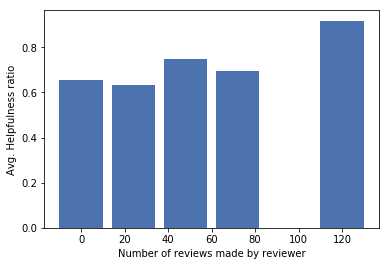

In [75]:
import math
author_reviews = {}
for index, entry in dataframe.iterrows(): 
    if math.isnan(entry.helpfulRatio):
        continue
    if entry.reviewerID not in author_reviews:
        author_reviews[entry.reviewerID] = []
    author_reviews[entry.reviewerID].append(entry.helpfulRatio)
num_reviews_to_avg_rating  = {len(v):(sum(v)/len(v)) for k,v in author_reviews.items()}

reviews=[[] for x in range(0,6)]
bins = np.linspace(0,120,6)
for num_review, avg_rating in num_reviews_to_avg_rating.items():
    reviews[int(num_review/20)].append(avg_rating)
    
num_reviews_per_bin = [len(x) for x in reviews]
reviews = [(sum(x)/len(x) if len(x)>0 else 0) for x in reviews]

plt.ylabel('Avg. Helpfulness ratio')
plt.xlabel('Number of reviews made by reviewer')
plt.bar(bins,reviews, width =20)
plt.show()

Another analysis of a relationship between attributes we decided to do is that of the relationship between the number of reviews each reviewer has done and the average helpfulness ratio he/she received. We decided to ignore entries that had NaN for helpfulRatio to ease us in the visualization of this relationship. The above graph shows clearly that the more reviews a certain reviewer has made, the higher average helpfulness ratio he received from fellow reviewers. This would be expected and suggests that more experienced reviewers leave comments that others find more useful. 